# The Boltzmann Bank

## Overview

The following models are very simple simulations of economic activity. It comprises many independent agents, called 'individuals', that "spend" money by randomly giving some to another individual; the money an individual receives from others is its "income". There are no goods or services in these models, hence no employment nor supply and demand nor any prices at all. They are solely intended to simulate a realistic monetary system.

In these models, money takes the form of bank liabilities: each individual has an account with a bank, and when they give money to another individual, the bank simply adjusts the account balances accordingly. Consequently, the bank has the ability to create more money by issuing more liabilities, which is to say by issuing a loan.

---

In this agent-based model there are many `Individual`s and a single `Bank`. The `Bank` provides a means of payment that the `Individual`s can use as money. Each turn, each `Individual` wants to give one unit of money to another `Individual`. If they can't (because they don't have enough money) they can choose instead to apply for a loan from the `Bank` as long as they are beneath their personal borrowing limit; otherwise they do nothing.

If an `Individual` has a loan due (or overdue) on a step, they will try to repay it before giving anyone else money. If they do not have enough money, they will apply for a loan if they are beneath their borrowing limit; otherwise, they will do nothing and hope to repay the loan later. If they do have enough to repay the loan, they will repay it; if there is any money leftover, they will give a unit to someone else.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from model import BoltzmannBank, Individual, LoanOption


---

## 1. Base model: no loans

Let's start with a simulation without any loans. In this model, individuals will be gifted a specifiable amount of money when they first open their account (during the initialization of the model). After that, the only way individuals can get more money is if they receive some from other individuals. The money supply will therefore be constant throughout the simulation.

In [2]:
no_loans_model = BoltzmannBank(
    num_individuals = 1000,
    init_gift = 5,
)

for _ in range(7*4*3):
    no_loans_model.step()

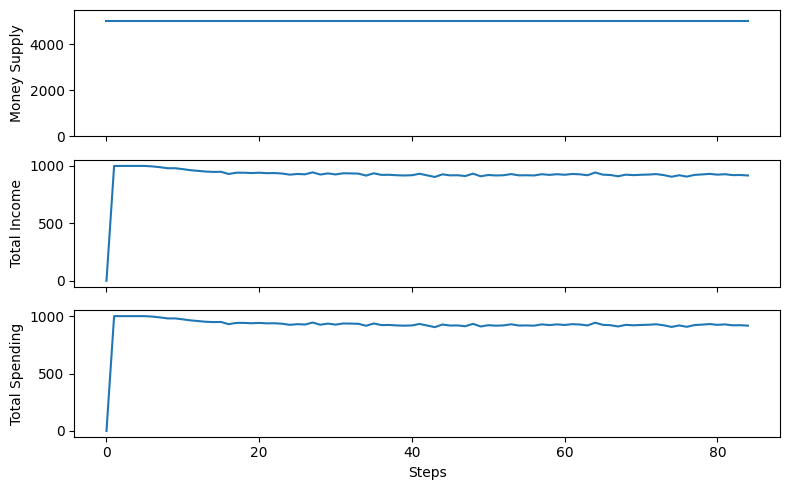

In [3]:
model_df = no_loans_model.datacollector.get_model_vars_dataframe()

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 5))

sns.lineplot(data=model_df["Money Supply"], ax=axes[0])
axes[0].set_ylabel("Money Supply")
axes[0].set_ylim(0, model_df["Money Supply"].max() * 1.1)

sns.lineplot(data=model_df["Total Income"], ax=axes[1])
axes[1].set_ylabel("Total Income")

sns.lineplot(data=model_df["Total Spending"], ax=axes[2])
axes[2].set_ylabel("Total Spending")

axes[2].set_xlabel("Steps")

plt.tight_layout()
plt.show();

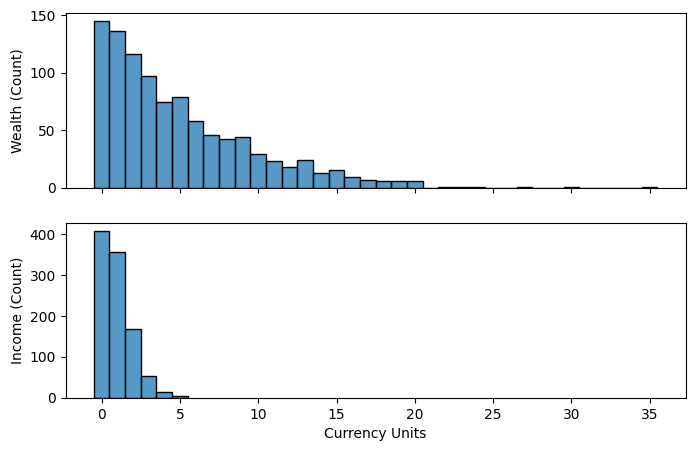

In [4]:
individual_df = no_loans_model.datacollector.get_agenttype_vars_dataframe(Individual).xs(no_loans_model.steps, level="Step")

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

sns.histplot(individual_df["Wealth"], discrete=True, ax=axes[0])
axes[0].set_ylabel("Wealth (Count)")

sns.histplot(individual_df["Income"], discrete=True, ax=axes[1])
axes[1].set_ylabel("Income (Count)")

axes[1].set_xlabel("Currency Units")

plt.show();



---

## 2. A model with loan applications

Now let's allow the bank to issue loans and thereby increase the amount of money available. Each individual will have a personal debt limit that caps the amount that they are willing to borrow. Whenever they don't have enough money to give some away and they are beneath their debt limit, they will apply for a loan from the bank. On its turn, the bank will review some number of loans and will issue liabilities for those it approves. (For now, the bank will approve all loans.)

The principal of the loans will be the minimum of the amount the individual needs for its spending, the amount of debt that they are able to take on, and a configurable maximum amount. The term (ie. duration) of the loan is also configurable.

In [5]:
loans_model = BoltzmannBank(
    num_individuals = 100,
    borrowing_limit = 1,
    loan_review_limit = 10,
)

for _ in range(100):
    loans_model.step()

## Visualization

In [6]:
model_df = loans_model.datacollector.get_model_vars_dataframe()
agent_df = loans_model.datacollector.get_agent_vars_dataframe()
individual_df = loans_model.datacollector.get_agenttype_vars_dataframe(Individual)

### The Money Supply

For our simple model, the money supply is entirely composed bank liabilities.

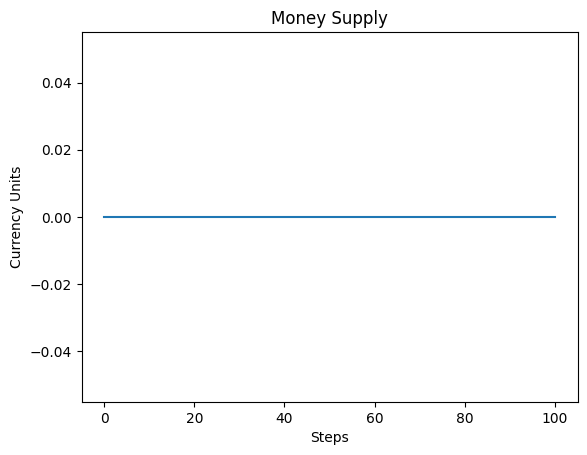

In [7]:
money_supply = model_df["Money Supply"]

g = sns.lineplot(data=money_supply)
g.set(title="Money Supply", xlabel="Steps", ylabel="Currency Units");

### Total Spending

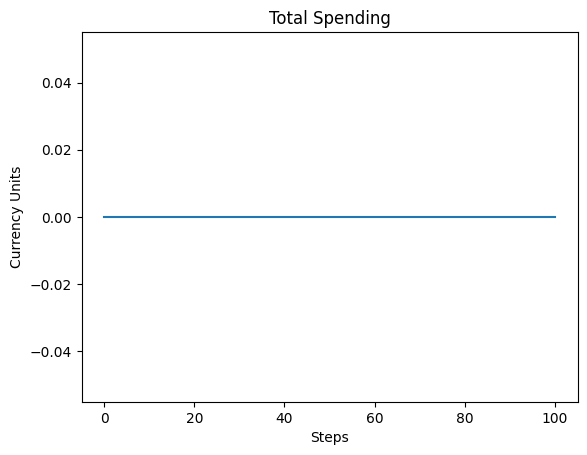

In [8]:
total_spending = model_df["Total Spending"]

g = sns.lineplot(data=total_spending)
g.set(title="Total Spending", xlabel="Steps", ylabel="Currency Units");

### The Individual Wealth Distribution

For our very simple model, each individual's wealth is its quantity of money, which is to say the balance of its bank account.

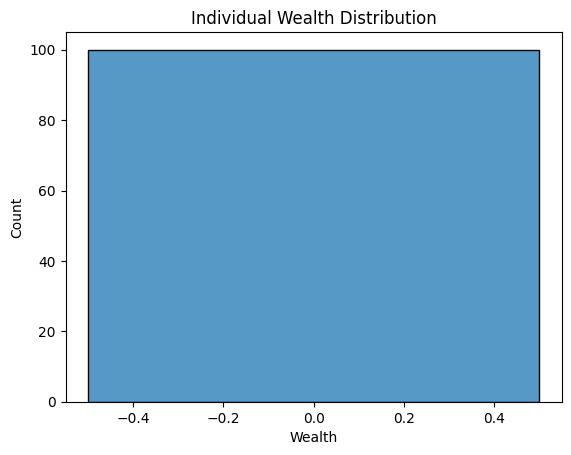

In [9]:
last_step = individual_df.index.get_level_values("Step").max()
wealth_curve = individual_df.xs(last_step, level="Step")["Wealth"].sort_values().values

g =sns.histplot(wealth_curve, discrete=True)
g.set(title="Individual Wealth Distribution", xlabel="Wealth");

### The Individual Wealth Gini Index

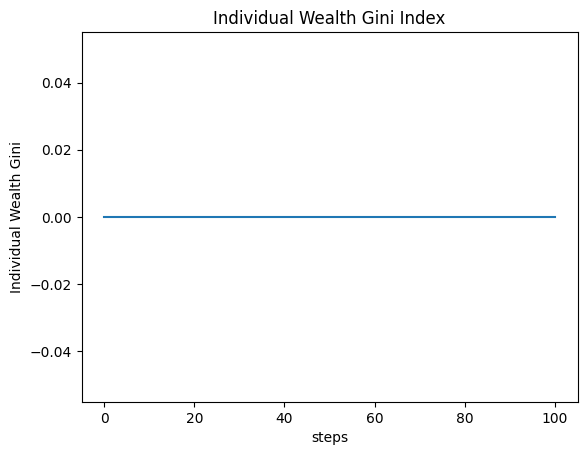

In [10]:
wealth_gini = model_df["Individual Wealth Gini"]

g = sns.lineplot(data=wealth_gini)
g.set(title="Individual Wealth Gini Index", xlabel="steps");

### The Individual Income Distribution

We can also look at the income distribution of our individuals.

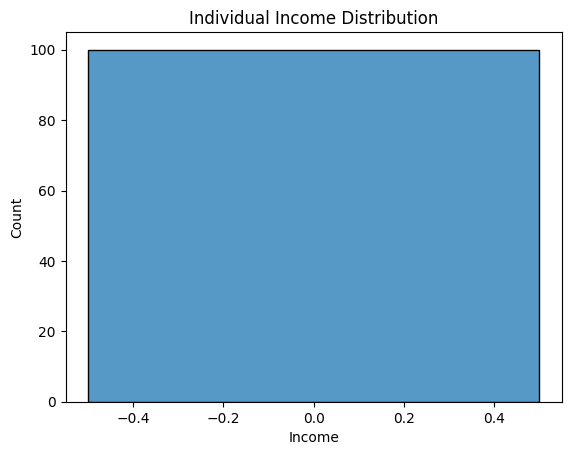

In [11]:
last_step = individual_df.index.get_level_values("Step").max()
income_curve = individual_df.xs(last_step, level="Step")["Income"].sort_values().values

g =sns.histplot(income_curve, discrete=True)
g.set(title="Individual Income Distribution", xlabel="Income");

### The Individual Income Gini Index

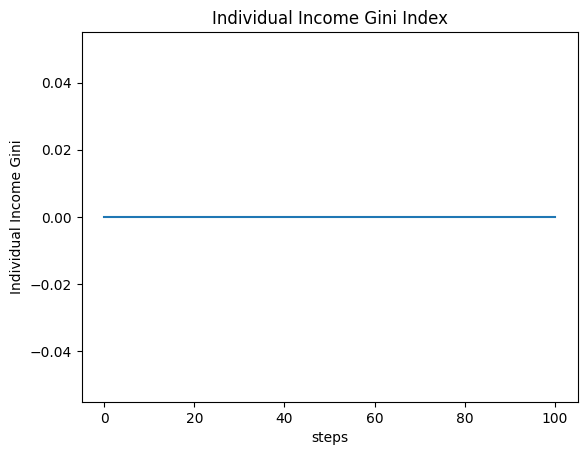

In [12]:
income_gini = model_df["Individual Income Gini"]

g = sns.lineplot(data=income_gini)
g.set(title="Individual Income Gini Index", xlabel="steps");

### The Individual Spending Distribution

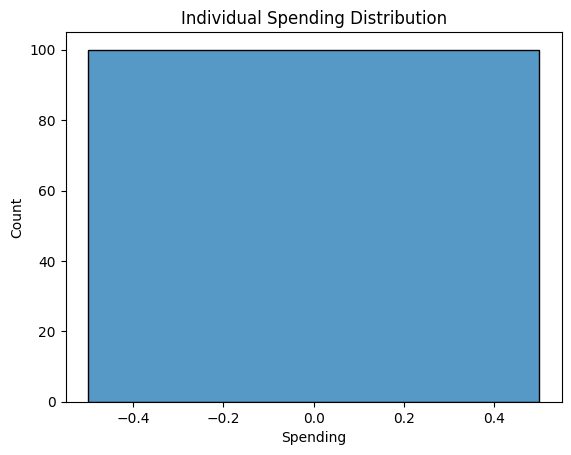

In [13]:
last_step = individual_df.index.get_level_values("Step").max()
spending_curve = individual_df.xs(last_step, level="Step")["Spending"].sort_values().values

g =sns.histplot(spending_curve, discrete=True)
g.set(title="Individual Spending Distribution", xlabel="Spending");

### The Individual Spending Gini Index

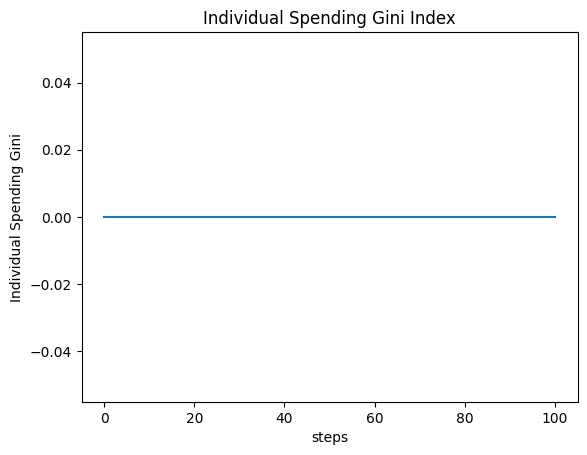

In [14]:
spending_gini = model_df["Individual Spending Gini"]

g = sns.lineplot(data=spending_gini)
g.set(title="Individual Spending Gini Index", xlabel="steps");

### Comparing the Distributions of Wealth, Income and Spending

In our very simple model, individuals accumulate wealth by having an income in excess of their spending.

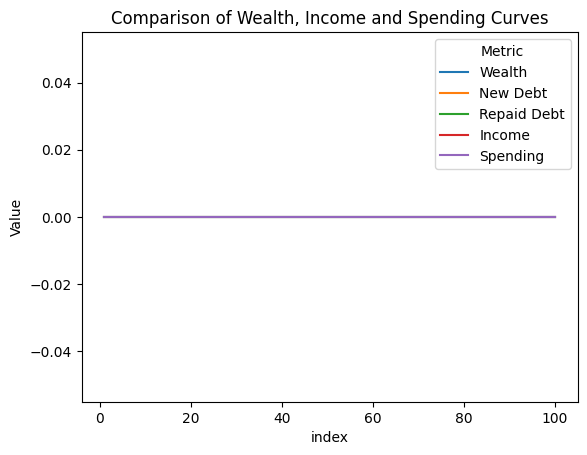

In [15]:
last_step = individual_df.index.get_level_values("Step").max()
wis_df = individual_df.xs(last_step, level="Step").sort_values(by="Wealth")
wis_df.index = range(1, len(wis_df) + 1)
long_wis_df = wis_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Value")

g = sns.lineplot(data=long_wis_df, x="index", y="Value", hue="Metric")
g.set(title="Comparison of Wealth, Income and Spending Curves");